In [1]:
# load some libraries
import sys
import os
import pickle
import gzip

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib as mpl

import darts
from darts import metrics

sys.path.append(os.path.abspath('./paper_results'))
from parser import avg_results

In [2]:
datasets = ['iglu', 'colas', 'dubosson', 'hall', 'weinstock'] # iglu is Broll in the paper, otherwise alphabetical order
models = ['arima', 'linreg', 'xgboost', 'gluformer', 'latentode',  'nhits', 'tft', 'transformer']
model_names = [f'../output/{model}_{dataset}.txt' for dataset in datasets for model in models]
model_names_with_covs = [f'../output/{model}_covariates_{dataset}.txt' for dataset in datasets for model in models]
model_name = {'arima': 'ARI', 'linreg': 'LIN', 'xgboost': 'XGB', 'gluformer': 'GLU', 'latentode': 'LAT', 'nhits': 'NHI', 'tft': 'TFT', 'transformer': 'TRA'}

(errors, likeli), (errors_std, likeli_std) = avg_results(model_names, model_names_with_covs)

In [3]:
def get_ratios():
    id_od_nocovs = errors['ood']['no_covs'] / errors['id']['no_covs'] 
    id_od_covs = errors['ood']['covs'] / errors['id']['covs']
    df = {i: [] for i in range(3)}
    
    for model in models:
        for dataset in datasets:
            idx = [i for i, x in enumerate(model_names) if x == f'../output/{model}_{dataset}.txt'][0]
            df[0] += [model_name[model]] * 2
            df[1] += [id_od_nocovs[idx, 0], id_od_covs[idx, 0]]
            df[2] += ['No covariates', 'With covariates']
    df = pd.DataFrame(df)
    df = df.dropna()
    df.reset_index(inplace=True)
    df = df[df[1] < 10]
    return df

def get_errors_with_std():
    df = {'model': [], 'dataset': [], 'error': [], 'error_std': []}
    dataset_name = dict(zip(datasets, ["Broll", "Colas", "Dubosson", "Hall", "Weinstock"]))

    for model in models:
        for dataset in datasets:
            idx = [i for i, x in enumerate(model_names) if x == f'../output/{model}_{dataset}.txt'][0]
            df['model'] += [model_name[model]]
            df['dataset'] += [dataset_name[dataset]]
            df['error'] += [errors['id']['no_covs'][idx, 1]]
            df['error_std'] += [errors_std['id']['no_covs'][idx, 1, 1]]
    df = pd.DataFrame(df)
    return df

def get_day_night_errors():
    # load day and night errors for transformer on IGLU (Broll)
    with gzip.open('./data/compressed_day_errors.pkl', 'rb') as file:
        day_errors = pickle.load(file)
    with gzip.open('./data/compressed_night_errors.pkl', 'rb') as file:
        night_errors = pickle.load(file)
    return day_errors[f'transformer_iglu'], night_errors[f'transformer_iglu']


/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning

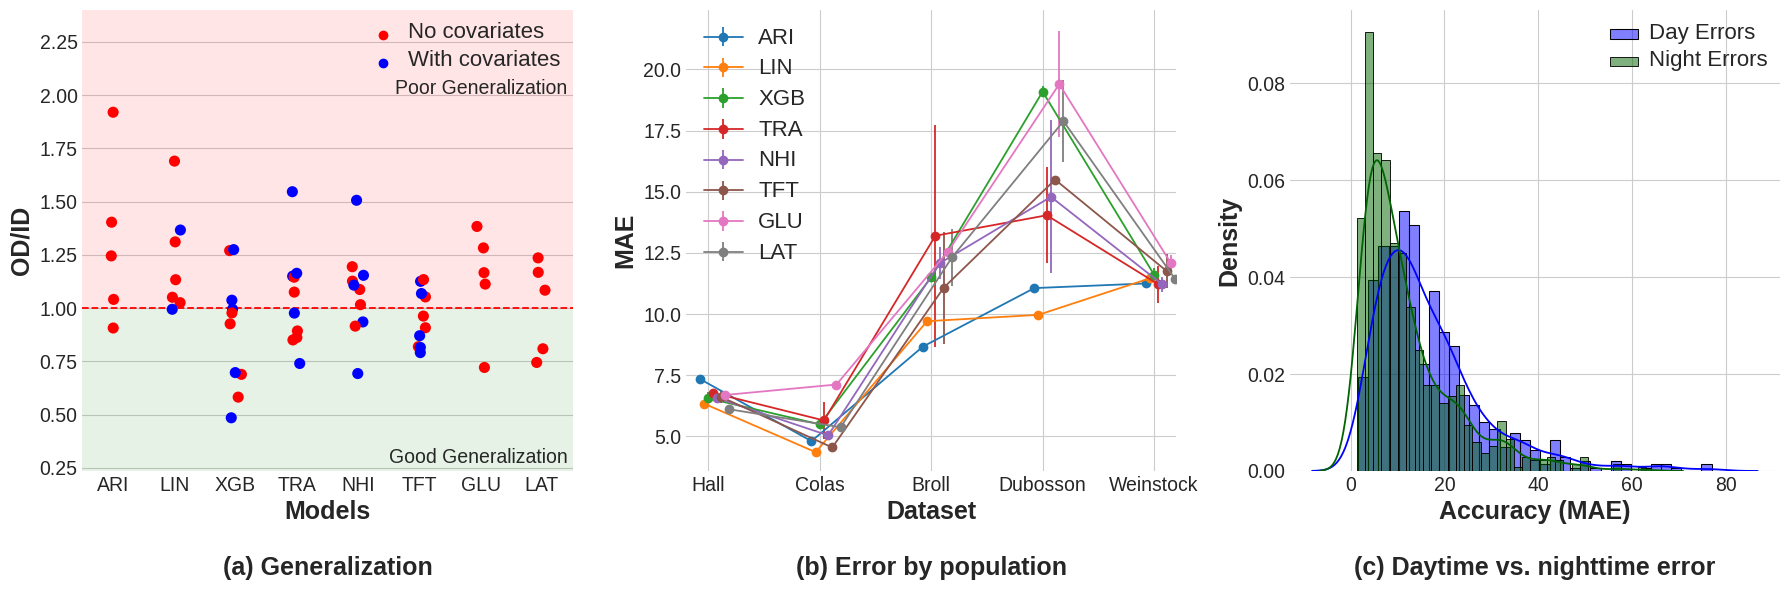

In [4]:
plt.style.use('seaborn-whitegrid')

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1: Plot OD / ID ratio
ax = axs[0]
df = get_ratios()
sns.stripplot(
    df,
    x=df[0],
    y=1,
    order=["ARI","LIN","XGB","TRA","NHI","TFT", "GLU", "LAT"], # TODO: update w/ gluformer & latent ode 
    hue=2, 
    size=8,
    palette=["r", "b"],
    ax=ax
)
ax.axhline(1, color="red", linestyle="--")
ax.set_ylabel("OD/ID", weight=900)
ax.set_xlabel("Models\n\n(a) Generalization", weight=900)
ax.set_ylim(bottom=None, top=2.4)
ax.axhspan(1, 2.5, facecolor="red", alpha=0.1)
ax.axhspan(0, 1, facecolor="green", alpha=0.1)
# put text in corners with font size 22
ax.text(0.99, 0.85, "Poor Generalization", ha='right', va='top', transform=ax.transAxes, fontsize=14)
ax.text(0.99, 0.05, "Good Generalization", ha='right', va='top', transform=ax.transAxes, fontsize=14)
ax.legend(loc="upper right")

# 2: Plot ID errors
ax = axs[1]
df_full = get_errors_with_std()
order = ["Hall","Colas","Broll","Dubosson","Weinstock"]
df_full = df_full.sort_values(by="dataset", key= lambda x: x.map({val: key for key, val in list(enumerate(order))}))
offset = lambda p: transforms.ScaledTranslation(p/72., 0, fig.dpi_scale_trans)
trans = ax.transData
palette = sns.color_palette('tab10')
for i, m in enumerate(["ARI","LIN","XGB","TRA","NHI","TFT", "GLU", "LAT"]): # TODO: update w/ gluformer
    df = df_full[(df_full["model"] == m)]
    # df = df.iloc[[3, 1, 0, 2, 4]] # order datasets ["Hall","Colas","Broll","Dubosson","Weinstock"]
    ax.errorbar(
        df["dataset"], 
        df["error"], 
        xerr=None, 
        yerr=1.96*df["error_std"], 
        label=m,
        markersize=6,
        fmt="-o",
        transform=trans+offset((i-2)*3),
        color=palette[i]
    )
ax.set_ylabel("MAE", fontsize=16, fontweight="bold")
ax.set_xlabel("Dataset\n\n(b) Error by population", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size': 14})

# 3: Plot day/night errors
day_errors_list, night_errors_list = get_day_night_errors()
ax = axs[2]
# plot normalized histogram with 50 bins
sns.histplot(day_errors_list, stat='density', alpha=0.5, 
        color='blue', label='Day Errors', ax=ax, bins=35)
sns.histplot(night_errors_list, stat='density', alpha=0.5, 
        color='darkgreen', label='Night Errors', ax=ax, bins=35)
# Plot density estimates of the two lists of values
sns.kdeplot(day_errors_list, color='blue', linestyle='-', ax=ax)
sns.kdeplot(night_errors_list, color='darkgreen', linestyle='-', ax=ax)
ax.legend(loc='upper right')
# set x and y labels
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Accuracy (MAE)\n\n(c) Daytime vs. nighttime error', fontsize=16)

# Change font size of labels and ticks
for ax in axs:
    # increase font size of all text
    for item in ([ax.xaxis.label, ax.yaxis.label]):
            item.set_fontsize(18)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(14)
    for item in ax.get_legend().get_texts():
            item.set_fontsize(16)

plt.tight_layout()
plt.savefig("./plots/figure4.pdf")
